# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [ ]:
# Download the data
if not os.path.exists('/content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('/content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

# Q3: Affine Motion Subtraction

## Q3.1: Dominant Motion Estimation (15 points)

In this case is a bit more complicated as

$$\begin{align}
\frac{\partial \mathbf{W}(\mathbf{x};\mathbf{p})}{\partial \mathbf{p}^{T}} &= \frac{\partial (\mathbf{M}\mathbf{x^*})}{\partial \mathbf{p}^{T}} \\
&= \frac{\partial}{\partial [p_1, p_2, p_3, p4_, p_5, p_6]} \begin{bmatrix}(1+p_1)x + p_2y + p_3 \\ p_4x + p_5y + p_6\end{bmatrix} \\
&= \begin{bmatrix}x & y & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & x & y & 1\end{bmatrix}
\end{align}$$

where 

$$\mathbf{M} := \begin{bmatrix} 1+p_1 & p_2 & p_3 \\ p_4 & 1+p_5 & p_6 \end{bmatrix}, \quad \quad \mathbf{x}^* := \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$

Then 

$$\begin{align}
\mathbf{A} &:= \frac{\partial \mathcal{I}(\mathbf{W}(\mathbf{x}; \mathbf{p}))}{\partial \mathbf{x}'^T} \frac{\partial \mathbf{W}(\mathbf{x}; \mathbf{p})}{\partial \mathbf{p}^T} \\
&= \nabla \mathcal{I} \begin{bmatrix}x & y & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & x & y & 1\end{bmatrix} \\
&= \begin{bmatrix} x\nabla\mathcal{I}_x & y\nabla\mathcal{I}_x & \nabla\mathcal{I}_x & x\nabla\mathcal{I}_y & y\nabla\mathcal{I}_y & \nabla\mathcal{I}_y\end{bmatrix} \end{align}$$

In [ ]:
from scipy.interpolate import RectBivariateSpline
from numpy.linalg import lstsq


def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ===== your code here! =====

    # Create interpolators for both images
    H, W = It.shape
    x = np.arange(W)
    y = np.arange(H)
    It_spline = RectBivariateSpline(y, x, It)
    It1_spline = RectBivariateSpline(y, x, It1)

    # Create a full image meshgrid
    x_t = np.linspace(0, W-1, W)
    y_t = np.linspace(0, H-1, H)
    rectX, rectY = np.meshgrid(x_t, y_t)

    # Flatten for processing
    flat_rectX = rectX.flatten()
    flat_rectY = rectY.flatten()

    # Evaluate the template image
    T = It_spline.ev(flat_rectY, flat_rectX)
    V = np.vstack([flat_rectX, flat_rectY, np.ones(flat_rectX.shape)]) # we predefine this for the loop later

    for _ in range(num_iters):
        
        # Apply current affine transform to the points
        newV = np.dot(M, V)
        newX, newY = newV[0, :], newV[1, :]

        # Interpolate It1 at new positions
        I_warp = It1_spline.ev(newY, newX)

        # Compute error image
        b = (T - I_warp).flatten()

        # Compute image gradients at warped locations
        Ix = It1_spline.ev(newY, newX, dy=1).flatten()
        Iy = It1_spline.ev(newY, newX, dx=1).flatten()

        # Construct the Jacobian (A matrix) for affine transformation -> recall the above equation for details 
        A = np.vstack([
            Ix * flat_rectX,  Ix * flat_rectY,  Ix,  
            Iy * flat_rectX,  Iy * flat_rectY,  Iy  
        ]).T  # Shape (N, 6)

        # Solve for delta_p using least squares
        delta_p, _, _, _ = lstsq(A, b, rcond=None)

        # Reshape delta_p into a (2,3) matrix  # [dp1, dp2, dp3, dp4, dp5, dp6] -> [[dp1, dp2, dp3],	 
        delta_M = delta_p.reshape(2, 3)        #                                    [dp4, dp5, dp6]]

        # Update transformation matrix M
        M += delta_M

        # Check for convergence
        if np.linalg.norm(delta_p) < threshold:
            break

    # ===== End of code =====
    return M

## Debug Q3.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

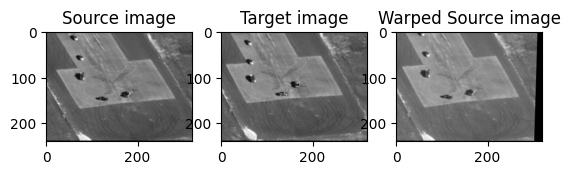

In [26]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("data/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = LucasKanadeAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

# Q3.2: Moving Object Detection (10 points)

In [ ]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====

    # Get affine transformation matrix
    M_full = LucasKanadeAffine(It, It1, threshold, num_iters)  # (2x3) affine matrix

    # Compute the inverse affine transformation
    # M_full = np.vstack([M_full, [0., 0., 1.]])  # (3x3)
    # M_inv = np.linalg.inv(M_full)[:2, :]  # Take only first two rows

    # # Apply affine transformation to warp `It` into `It1`'s coordinate frame
    # It_warped = affine_transform(It, M_inv[:, :2], offset=M_inv[:, 2], mode='nearest')
    It_warped = cv2.warpAffine(It, M_full, (It.shape[1], It.shape[0]))

    # Compute the binary mask
    diff = np.abs(It1 - It_warped)
    # addaptive_threshold = np.mean(diff) + tolerance # depending on each frames  values
    # mask0 = diff > addaptive_threshold
    mask0 = diff > tolerance

    # # Erode and dilate
    mask1 = binary_erosion(mask0, structure=np.ones((1,1)))  # Remove noise
    mask = binary_dilation(mask1, iterations=2)              # Expand moving regions

    # Remove border error generated by affine transformation
    border_mask = np.zeros(It.shape, dtype=bool)
    k = int(0.05 * It.shape[0])
    border_mask[k:-k, k:-k] = True

    mask = np.logical_and(mask, border_mask)
    # ===== End of code =====
    return mask


In [ ]:
"""This is another version for the SubtractDominantMotion which also worked well"""

import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion_v2(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====

    # Get affine transformation matrix
    M_full = LucasKanadeAffine(It, It1, threshold, num_iters)  # (2x3) affine matrix

    # Compute the inverse affine transformation
    M_full = np.vstack([M_full, [0., 0., 1.]])  # (3x3)
    M_inv = np.linalg.inv(M_full)[:2, :]  # Take only first two rows

    # Apply affine transformation to warp `It` into `It1`'s coordinate frame
    It_warped = affine_transform(It, M_inv[:, :2], offset=M_inv[:, 2], mode='nearest')

    # Compute the binary mask
    diff = np.abs(It1 - It_warped)
    addaptive_threshold = np.mean(diff) + tolerance # depending on each frames  values
    mask0 = diff > addaptive_threshold

    # Erode and dilate
    mask1 = binary_erosion(mask0, structure=np.ones((1,1)))  # Remove noise
    mask = binary_dilation(mask1, iterations=2)              # Expand moving regions

    # ===== End of code =====

    return mask


## Q3.3: Tracking with affine motion (10 points)

In [4]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    masks = []
    It = seq[:,:,0]

    # ===== your code here! =====
    for i in tqdm(range(1, N)):
        It1 = seq[:,:,i]
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)
        It = It1

    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

## Q3.3 (a) - Track Ant Sequence

In [57]:
seq_= np.load("data/antseq.npy")

In [60]:
# seq = np.load("data/antseq.npy")
seq = seq_

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq[:,:,:], num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [00:44<00:00,  2.78it/s]


Ant Sequence takes 44.719970 seconds


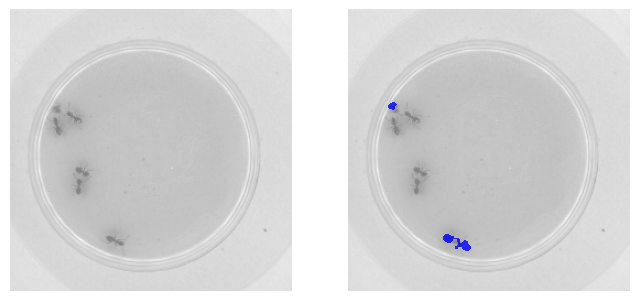

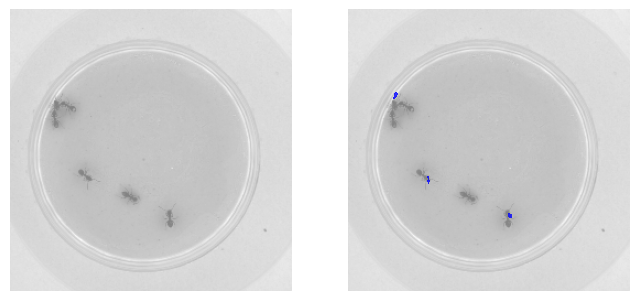

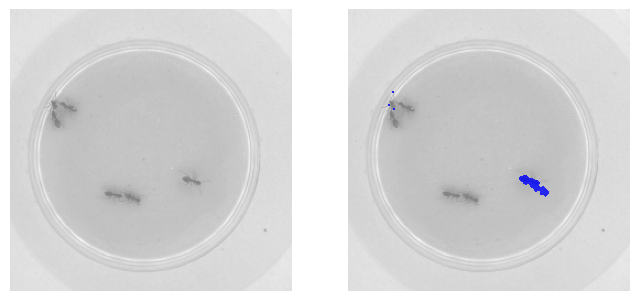

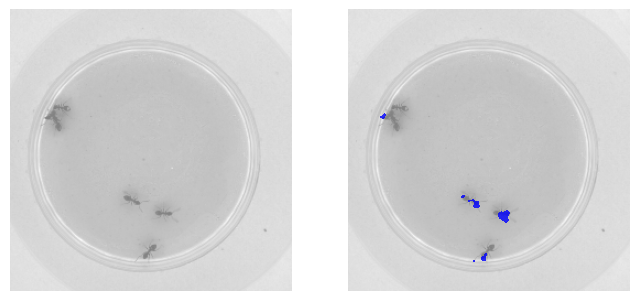

In [61]:
frames_to_save = [29, 59, 89, 119]
# frames_to_save = [5, 10, 15, 18]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')
plt.show()


Given this results I thought was something wrong with the code as some of the ants where correctly detected and not other. The point here is that we are detecting motion not object, thus some might moved relative to the previous frame and other not. This result can be clearly seen in a life video of the ants moving and checking which are being detected and which one not.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

def create_motion_gif(frames, masks, output_path="motion.gif", fps=10):
    """
    Creates a GIF overlaying masks on frames.
    
    :param frames: List of grayscale images (H, W)
    :param masks: List of binary masks (H, W) corresponding to each frame
    :param output_path: Output path for saving the GIF
    :param fps: Frames per second for the GIF
    """

    assert len(frames) == len(masks), "Frames and masks must have the same length"

    images = []
    for frame, mask in zip(frames, masks):
        fig, ax = plt.subplots(figsize=(5, 5))

        # Display grayscale frame
        ax.imshow(frame, cmap="gray", alpha=0.5)

        # Overlay mask with 'winter' colormap
        ax.imshow(np.ma.masked_where(~mask, mask), cmap="winter", alpha=0.8)

        ax.axis("off")  # Hide axes

        # Convert figure to image
        fig.canvas.draw()
        image = np.array(fig.canvas.renderer.buffer_rgba())

        images.append(image)
        plt.close(fig)  # Close figure to free memory

    # Save as GIF
    imageio.mimsave(output_path, images, fps=fps)
    print(f"GIF saved at {output_path}")

In [62]:
create_motion_gif([seq[:,:,i] for i in range(1,seq.shape[2])], [masks[:,:,i] for i in range(masks.shape[2])], "ants.gif", fps=10)

GIF saved at ants.gif


![Motion GIF](./ants.gif)

### Q3.3 (b) - Track Aerial Sequence

In [53]:
seq = np.load("data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.22

tic = time.time()
masks = TrackSequenceAffineMotion(seq[:,:,:], num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [01:43<00:00,  1.44it/s]


Ant Sequence takes 103.400878 seconds


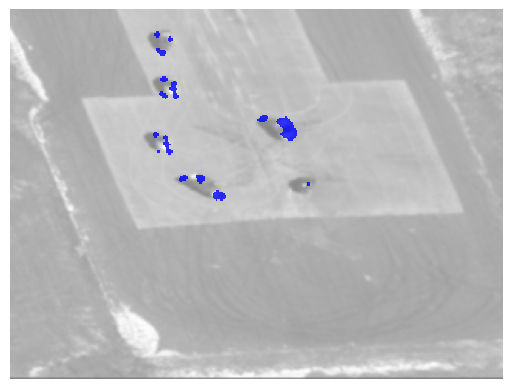

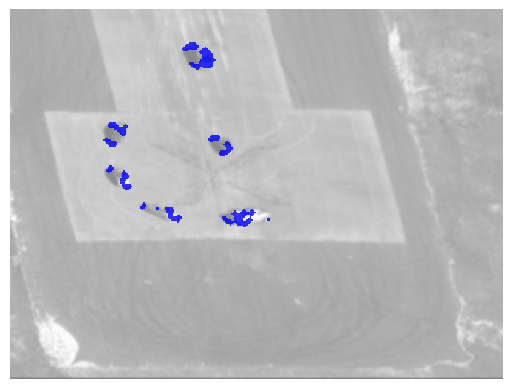

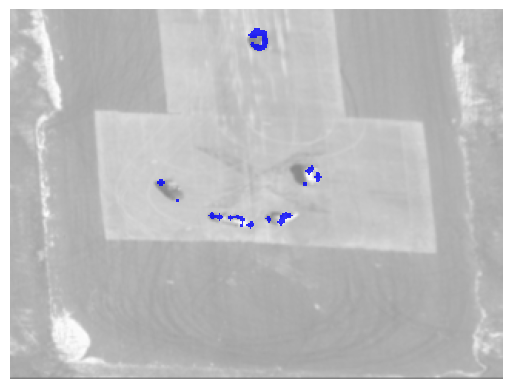

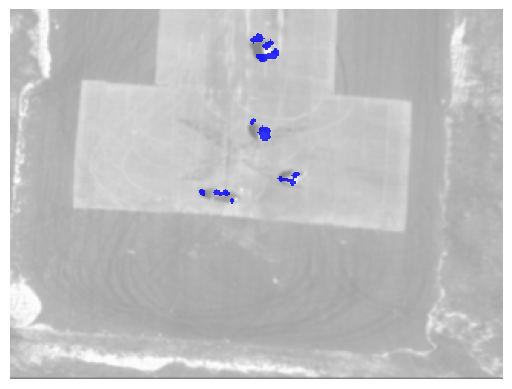

In [54]:
frames_to_save = [29, 59, 89, 119]
# frames_to_save = [2, 4, 6, 8]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')

In [55]:
create_motion_gif([seq[:,:,i] for i in range(1,seq.shape[2])], [masks[:,:,i] for i in range(masks.shape[2])], "cars.gif", fps=10)


GIF saved at cars.gif


![](cars.gif)